In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme()

In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch.optim as optim

In [23]:
#! Hyperparameters

# 1 layer of 50 neurons
# loss function: mean root square error
# optimizer: stochastic gradient descent
# epocs = 200

batch_size = 64
validation = .2
learning_rate = .01
seed = 42 # the answet to life, the universe & everything
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [24]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
df = pd.read_csv("Data/Processed/data.csv")
X = df.loc[:, df.columns != 'glucose_t+1']
y = df["glucose_t+1"]

In [26]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

train_data = TabularDataset(X_train, y_train)
val_data = TabularDataset(X_val, y_val)
test_data = TabularDataset(X_test, y_test)

In [27]:
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
validation_loader = DataLoader(val_data, batch_size=batch_size) 

In [33]:
# Define the Neural Network
class BaseLine(nn.Module):
    def __init__(self, input_dim):
        super(BaseLine, self).__init__()
        self.fc = nn.Linear(input_dim, 50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.output(x)

# Define MAPE/MARD Loss function
def MAPELoss(preds, targets, epsilon = 1e-8): # epsilon prevents division by 0
    return torch.mean(torch.abs((targets - preds) / (targets + epsilon))) * 100

In [34]:
# Initialize model, optimizer
input_dim = X.shape[1]
model = BaseLine(input_dim=input_dim)
optimizer = optim.SGD(model.parameters())

# Training & Validation
num_epochs = 400
train_loss_mape = []
val_loss_mape = []

In [35]:
list(model.parameters())

[Parameter containing:
 tensor([[ 3.8938e-02, -5.1326e-04,  8.9487e-02, -1.8998e-01,  1.9942e-01,
           2.3512e-01, -2.4532e-01,  3.4250e-03],
         [ 9.8097e-04,  1.1353e-01,  3.2936e-01,  1.0368e-01, -8.0335e-02,
           3.1754e-01, -1.3454e-01, -1.0266e-01],
         [ 2.4139e-02, -2.6923e-01,  3.8473e-02, -2.3988e-01,  3.6353e-02,
           3.3873e-02,  4.8939e-02, -2.9815e-01],
         [-3.3580e-01,  1.6268e-01,  3.0321e-01, -3.1373e-01,  1.3095e-01,
          -2.6026e-01,  2.2165e-02,  3.2893e-01],
         [ 2.6821e-01, -2.5850e-01,  2.1870e-01,  1.8467e-01, -5.4230e-04,
           3.4250e-01, -1.4042e-01, -8.2277e-02],
         [-1.7869e-01,  5.0875e-02,  9.3616e-02,  2.8171e-02, -1.9892e-01,
          -1.5916e-01,  1.2026e-01, -3.1000e-01],
         [-5.5060e-02, -7.8318e-03, -1.4325e-01,  1.2866e-01,  2.2788e-02,
           2.4822e-01, -3.1400e-02, -2.2314e-01],
         [ 2.4980e-01,  4.9373e-02, -1.0126e-01, -2.3303e-01,  8.2869e-02,
          -3.3720e-01,  9.3

In [36]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_y = batch_y.view(-1, 1).float()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = MAPELoss(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_mape.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in validation_loader:
            val_y = val_y.view(-1, 1).float()
            preds = model(val_X)
            loss = MAPELoss(preds, val_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_loader)
    val_loss_mape.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train MAPE: {avg_train_loss:.4f}% | Val MAPE: {avg_val_loss:.4f}%")



Epoch 1/400 | Train MAPE: 23.0735% | Val MAPE: 12.1818%
Epoch 2/400 | Train MAPE: 13.8980% | Val MAPE: 10.3739%
Epoch 3/400 | Train MAPE: 13.4210% | Val MAPE: 8.6484%
Epoch 4/400 | Train MAPE: 13.1948% | Val MAPE: 8.2926%
Epoch 5/400 | Train MAPE: 13.0384% | Val MAPE: 8.3479%
Epoch 6/400 | Train MAPE: 12.9720% | Val MAPE: 18.1694%
Epoch 7/400 | Train MAPE: 13.1205% | Val MAPE: 19.7961%
Epoch 8/400 | Train MAPE: 12.9620% | Val MAPE: 19.0264%
Epoch 9/400 | Train MAPE: 13.0163% | Val MAPE: 19.2638%
Epoch 10/400 | Train MAPE: 12.9761% | Val MAPE: 18.7488%
Epoch 11/400 | Train MAPE: 12.9598% | Val MAPE: 18.9784%
Epoch 12/400 | Train MAPE: 12.8712% | Val MAPE: 18.9606%
Epoch 13/400 | Train MAPE: 12.9029% | Val MAPE: 19.2578%
Epoch 14/400 | Train MAPE: 12.8588% | Val MAPE: 17.9755%
Epoch 15/400 | Train MAPE: 12.8149% | Val MAPE: 17.7586%
Epoch 16/400 | Train MAPE: 12.7996% | Val MAPE: 17.8391%
Epoch 17/400 | Train MAPE: 12.8120% | Val MAPE: 18.6046%
Epoch 18/400 | Train MAPE: 12.7854% | Val M

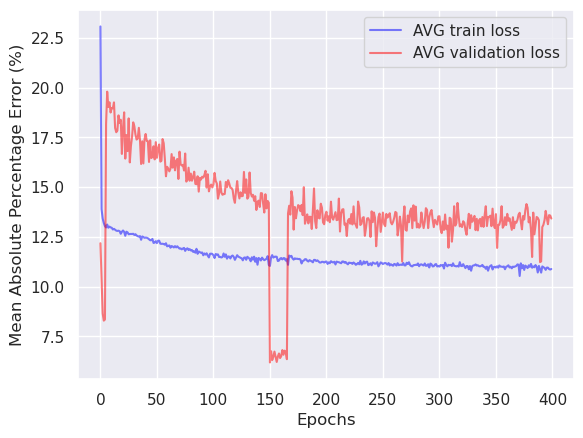

In [37]:
fig, ax = plt.subplots()
ax.plot(train_loss_mape, color = "blue", label = "AVG train loss", alpha = .5)
ax.plot(val_loss_mape, color = "red", label = "AVG validation loss", alpha = .5)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Percentage Error (%)")
plt.legend()
plt.show()